In [1]:
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from datetime import datetime
from wordcloud import WordCloud
import time
import tweepy
import re
import matplotlib.pyplot as plt
from pprint import pprint
import sys
# path to tweepy keys
sys.path.append('')

In [2]:
import tweepy_credentials as config

In [3]:
auth = tweepy.OAuthHandler(config.CONSUMER_KEY, config.CONSUMER_SECRET)
auth.set_access_token(config.ACCESS_TOKEN, config.ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True,retry_count=6)

In [4]:
def calcTime(numTweets, sleepFrequency, sleepSeconds):
    """returns number of minutes to get all tweets"""

    times_to_stop = numTweets/sleepFrequency
    # sleep time & time to grab 20 tweets each time
    seconds = (times_to_stop * sleepSeconds) + (times_to_stop * 3) 
    minutes = seconds / 60
    return round(int(minutes))


def getTweets(userHashtag, numTweets, sleepFrequency, sleepSeconds):
    """returns tuple of dict and list """

    times = calcTime(numTweets, sleepFrequency, sleepSeconds)
    print('This will take about {} minutes'.format(times))

    tweet_text=[]
    tweetDict = {}
    count = 0
    start = True
    while start:
        for tweet in tweepy.Cursor(api.user_timeline, screen_name= userHashtag).items(): # set user
            tweet_text.append(tweet.text)
            tweetDict.setdefault(tweet.created_at, []).append(tweet.text)
            count+=1
            #print('\n{} || {}\n{}'.format(count, tweet.text, tweet.created_at))

            if count % int(sleepFrequency) == 0:
                time.sleep(int(sleepSeconds))

            if count == int(numTweets): # set number of tweets to get
                #print('done')
                start=False
                break
    return tweetDict, tweet_text

In [5]:
userHashtag = '@realDonaldTrump'
numTweets = 1000 # number of tweets to get
sleepFrequency = 20 # sleep every 20 tweets
sleepSeconds = 10 # sleep 10 seconds every 20 tweets

tweetData = getTweets(userHashtag, numTweets, sleepFrequency, sleepSeconds)

This will take about 10 minutes


In [20]:
def tweetCleaner(tweetList):
    """transform tweets to list of cleaned strings  """
    clean_tweets=[]
    for i in tweetList:
        a= re.sub(r'http\S+', '', i)#removes all links
        b = re.sub(r'RT.*?:', '', a)#removes all 'RT...:' at beginning 
        c = re.sub(r'[#]\S*','', b) #removes all #hashtags
        d= re.sub(r'[@]\S*','', c) # removes all @ symbols 
        clean_tweets.append(d)
        
        
    cleaner_tweets = []
    for i in clean_tweets:
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
        cleaner_tweets.append(emoji_pattern.sub(r'', i))
        
    cleanest_tweets=[]
    for i in cleaner_tweets:
        y = re.sub(r'[^\w\s]','', i)
        x = y.replace('\n', '').replace('\r', '')
        w = x.replace('    ', '').replace("amp", "")
        if w.isdigit() == True:
            pass
        else:
            cleanest_tweets.append(w)
    return cleanest_tweets

In [7]:
def stemTweets(cleaneTweetList):
    
    #stemmer = PorterStemmer()

    nltk_lst = []
    for i in cleaneTweetList:
        split = i.split()
        nltk_lst.extend(split)
    
    no_stop_words = []
    for i in nltk_lst:
        lower = i.lower()
        if lower not in stopwords.words('english'):
            #if len(lower) > 3: # exclude i letter words 
            no_stop_words.append(lower)
    
    return no_stop_words

In [8]:
clean_tweets = tweetCleaner(tweetData[1])
no_stop_words = stemTweets(clean_tweets)

In [9]:
def filter_months(tweetDict, datetimeStart, datetimeEnd):
    """give datetime:tweet dict & datetime objects, returns TOTALLY cleaned list"""
    
    monthTweet = []
    date = []
    for k,v in tweetDict.items():
        # get tweets between certain dates
        if datetimeStart < k < datetimeEnd:
            monthTweet.append(v)
            date.append(k)
    print("Found: {} tweets found between {} - {}".format(len(date), datetime.date(date[0]), datetime.date(date[-1])))
            
            
    one = [j for i in monthTweet for j in i]

    lst = []
    for i in one:
        split = i.split()
        lst.extend(split)
        
    cleaned = tweetCleaner(lst)   
    stemmed= stemTweets(cleaned)
    
    wordCloud_lst = []
    for i in stemmed:
        if i != 'i' and len(i) != 1 and i not in ['rt', 'trump']: # exclude certain words
            wordCloud_lst.append(i)
            #print(i)
    return wordCloud_lst

# filter tweets by date

In [18]:
start = datetime(2017, 7, 1)
end = datetime(2017, 10, 8)

listTweets = filter_months(tweetData[0], start, end)
len(listTweets)

Found: 847 tweets found between 2017-10-07 - 2017-07-01


8758

# exclude words that appear below a specific frequency

In [11]:
def filterCounter(listTweets, num):
    """using list of filtered by month, stemmed, & cleaned tweets, 
       create counter dict & return words that appear above defined frequency"""

    frequencyDict = Counter(listTweets)

    filtDict = {}
    keepWords = []
    trashWords = []
    for k,v in frequencyDict.items():
        trashWords.append(k)
        if v > int(num): # change here 
            keepWords.append(k)
            filtDict[k] = v
    print('Different words above {} times: {}\nDifferent words below {} times: {}\nDifference: {}'.format(str(num), len(keepWords), str(num), len(trashWords), (len(trashWords) - len(keepWords))))

    # sort dict value greatest to least 
    filtDictSorted = sorted(filtDict.items(), key=lambda x: int(x[1]), reverse=True)

    cloudList = []
    for i in filtDictSorted:
        cloudList.append(i[0])
    return cloudList

In [12]:
cloudList = filterCounter(listTweets, 2)

Different words above 2 times: 283
Different words below 2 times: 1378
Difference: 1095


# turn list into a long string & plot

In [13]:
def listToWordCloud(listOfStrings, filename=None):
    '''inputs are a vertical list'''
    
    wordcloud_text = " ".join([word for word in listOfStrings])
    wordcloud = WordCloud().generate(wordcloud_text)
    
    if filename:
        wordcloud.to_file(filename + '.jpg')
        print('saving file')
        
    image = wordcloud.to_image()
    return image.show()

In [14]:
listToWordCloud(cloudList)

# or show it in the notebook with matplot

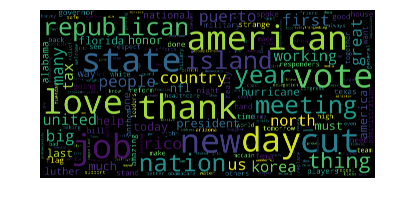

In [19]:
text = " ".join([i for i in cloudList])

wordcloud = WordCloud(max_font_size=40,
                      scale=20,
                     ).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()